In [38]:
import pathlib
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.svm
import tabulate
import tensorflow as tf

from link_bot_data.visualization import noisey_1d_scatter
from moonshine.gpu_config import limit_gpu_mem

#plt.style.use("slides")
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True, linewidth=250)


limit_gpu_mem(0.5)

In [30]:
def myshorten(string: str):
    parts = re.split("/", string)
    indices = [3]
    shortened = '-'.join([parts[i] for i in indices])
    return shortened

infiles = {
'car': 'results/classifier_data/val_car_feasible_1614981888/val_car_feasible_ensemble/results_1616172209.npz',
'empty': 'results/classifier_data/results/empty1/val_car_feasible_ensemble/results_1616173437.npz',
'long hook': 'results/classifier_data/val_long_hook_1616587237/none/results_1617288616.npz',
'ring': 'results/classifier_data/val_ring_1617119744/none/results_1617289835.npz',
'deadend': 'results/classifier_data/val_deadend_1617235474/val_car_feasible_ensemble/results_1617291138.npz',
'slit': 'results/classifier_data/val_slit_1617224535/val_car_feasible_ensemble/results_1617290819.npz',
# 'full': '',
    # OLD DATASETS
# 'rack' : 'results/classifier_data/val_rack_1616169743/none/results_1616179679.npz',
# 'planning, party' : 'results/classifier_data/results/party1/none/results_1616175621.npz',
# 'planning, car': 'results/classifier_data/results/fss-no-starts-far-classifier-1/val_car_feasible_ensemble/',
}


dfs = {}
for name, infile in infiles.items():
    infile_path = pathlib.Path(infile)
    df = np.load(infile)
    print(name, list(df.keys()))

    actual_data_keys = [
        'stdevs',
        'is_correct',
        'probabilities',
        'labels',
        'error',
    ]
    actual_data = {k : df[k] for k in actual_data_keys}

    df = pd.DataFrame(data=actual_data)
    dfs[name] = df

names = list(dfs.keys())

car ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
empty ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
long hook ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
ring ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
deadend ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
slit ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']


In [31]:
for name, df in dfs.items():
    print(df)

         stdevs  is_correct  probabilities  labels     error
0      0.245228       False       0.262635     1.0  0.040998
1      0.000430        True       0.000354     0.0  0.159969
2      0.000179        True       0.000340     0.0  0.147804
3      0.001308        True       0.998961     1.0  0.024696
4      0.014050        True       0.991813     1.0  0.022849
...         ...         ...            ...     ...       ...
36539  0.010938        True       0.990109     1.0  0.024242
36540  0.000278        True       0.999791     1.0  0.016702
36541  0.000067        True       0.000125     0.0  0.280492
36542  0.007699        True       0.996123     1.0  0.013666
36543  0.000153        True       0.000146     0.0  0.218336

[36544 rows x 5 columns]
       stdevs  is_correct  probabilities  labels     error
0    0.196175       False       0.870169     0.0  0.057227
1    0.000047        True       0.999944     1.0  0.026651
2    0.000242        True       0.999791     1.0  0.028010
3    0

In [32]:
table = []
for name, df in dfs.items():
    stdevs = df['stdevs']
    table.append((name, stdevs.mean(), stdevs.std()))
print(tabulate.tabulate(table, headers=['name', 'mean', 'std'], floatfmt='.3f'))


name         mean    std
---------  ------  -----
car         0.063  0.113
empty       0.070  0.105
long hook   0.101  0.126
ring        0.111  0.133
deadend     0.109  0.130
slit        0.106  0.127


In [134]:
# Can the mean output probability of the ensemble tell us whether the classifier is wrong?
# one problem with this analysis is that the class balance is going to be different between each plot,
# as well as between the correct/incorrect, so I'm not sure I can interpret these results correctly.
def make_max_class_prob(probabilities):
    other_class_probabilities = 1 - probabilities
    return np.maximum(probabilities, other_class_probabilities)

stdev_normalizing_factor = np.max(dfs['car']['stdevs'])

def stdev_score(x, beta=1):
    x = x / stdev_normalizing_factor
    return 1 - beta * (x / (x + 1))

def combine_mcp_and_stdev_score(stdev_scores, mcp):
    alpha = 0.7
    return alpha * stdev_scores + (1 - alpha) * mcp
    # return np.maximum(alpha * stdev_scores, (1 - alpha) * mcp)

def compute_widths(datasets):
    sizes = np.array([d.size for d in datasets])
    return sizes / np.max(sizes)

def gen():
    for name, df in dfs.items():
        stdevs = df['stdevs']
        is_correct = df['is_correct']
        probabilities = df['probabilities']

        mcp = make_max_class_prob(probabilities)

        yield name, stdevs, mcp, is_correct

def gen_xy():
    for name, stdevs, mcp, is_correct in gen():
        X = np.stack([stdevs, mcp], axis=1)
        y = is_correct

        yield name, X, y

In [135]:
# how accurately can we predict error given stdev and mcp??
m = tf.keras.metrics.BinaryAccuracy()

print("SVM on a per-dataset basis")
for name, X, y in gen_xy():
    svm = sklearn.svm.LinearSVC().fit(X, y)
    y_pred = svm.predict(X)
    m.reset_states()
    m.update_state(y_true=y, y_pred=y_pred)
    accuracy = m.result().numpy() * 100
    print(f"{name:14s} {accuracy:.1f}%")
    # print(svm.coef_, svm.intercept_)

SVM on a per-dataset basis
car            91.1%
[[0.35601692 2.62795941]] [-1.67525528]
empty          81.8%
[[-5.37279674  1.2870797 ]] [-0.8511255]
long hook      86.0%
[[-0.20240178  1.71527597]] [-0.82639304]
ring           92.0%
[[0.53413406 2.45561638]] [-1.46511157]
deadend        88.9%
[[-0.37075766  1.42599688]] [-0.48039095]
slit           91.5%
[[0.28236564 2.1829322 ]] [-1.19064034]


In [133]:
def ensemble_classifier(mcp, stdev):
    A = np.array([1, 1], np.float32)
    B = np.array(0, np.float32)
    return np.stack([stdev, mcp], axis=1) @ A + B

print("hand-designed linear model")
for name, stdevs, mcp, is_correct in gen():
    y = is_correct
    y_pred2 = ensemble_classifier(mcp, stdevs)
    m.reset_states()
    m.update_state(y_true=y, y_pred=y_pred2)
    accuracy = m.result().numpy() * 100
    print(f"{name:14s} {accuracy:.1f}%")

hand-designed linear model
car            90.7%
empty          52.1%
long hook      86.0%
ring           92.0%
deadend        88.9%
slit           91.5%


In [137]:
X = np.ndarray([0,2])
y = np.ndarray([0])
print("Train one SVM")
for name, x_i, y_i in gen_xy():
    X = np.concatenate([X, x_i])
    y = np.concatenate([y, y_i])

print(X.shape, y.shape)
all_svm = sklearn.svm.LinearSVC().fit(X, y)
print("done")

Train one SVM
(77184, 2) (77184,)


In [138]:
print(all_svm.coef_, all_svm.intercept_)

[[0.20057761 2.24315289]] [-1.29731397]


In [139]:
print("Test one SVM on individual datasets")
for name, df in dfs.items():
    stdevs = df['stdevs']
    error = df['error']
    is_correct = df['is_correct']
    probabilities = df['probabilities']
    mcp = make_max_class_prob(probabilities)

    X = np.stack([stdevs, mcp], axis=1)
    y = is_correct

    y_pred = all_svm.predict(X)
    m.reset_states()
    m.update_state(y_true=y, y_pred=y_pred)
    accuracy = m.result().numpy() * 100
    print(f"{name:14s} {accuracy:.1f}%")


Test one SVM on individual datasets
car            91.0%
empty          52.0%
long hook      86.1%
ring           91.9%
deadend        88.6%
slit           91.5%


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


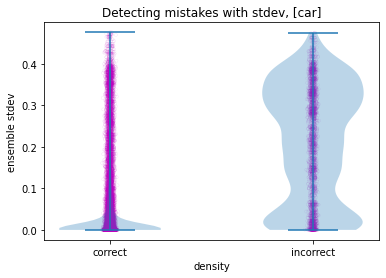

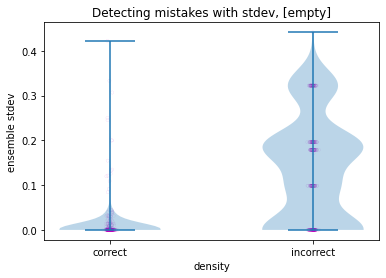

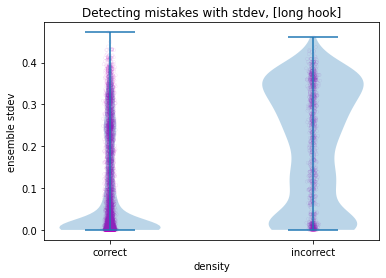

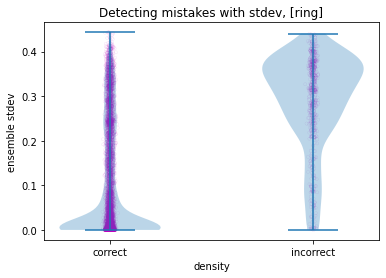

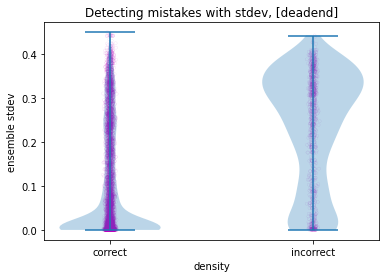

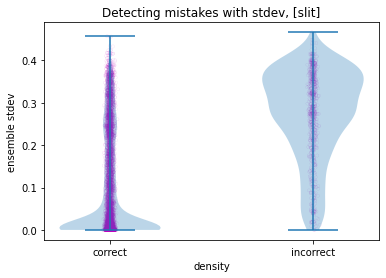

In [35]:
# Can the ensemble stdev tell us whether the classifier is wrong?

for name, df in dfs.items():
    stdevs = df['stdevs']
    is_correct = df['is_correct']

    is_correct_indices = np.argwhere(is_correct).squeeze()
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct)).squeeze()

    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with stdev, [{name}]')
    noisey_1d_scatter(ax, stdevs_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    noisey_1d_scatter(ax, stdevs_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    # widths = compute_widths([stdevs_correct, stdevs_incorrect])
    widths = [0.5, 0.5]
    ax.violinplot([stdevs_correct, stdevs_incorrect], [1, 2], widths=widths)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("ensemble stdev")

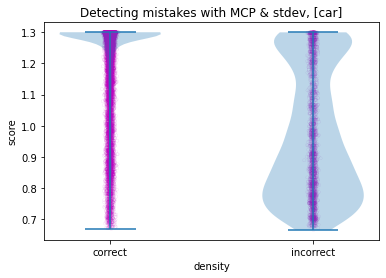

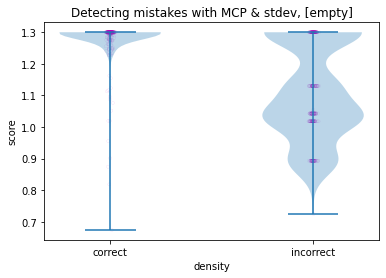

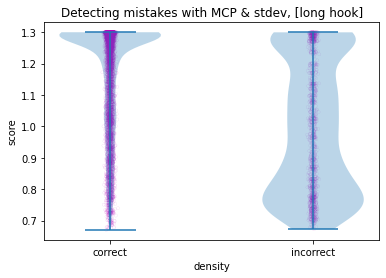

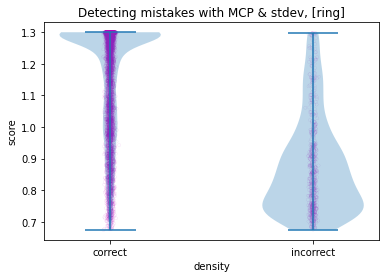

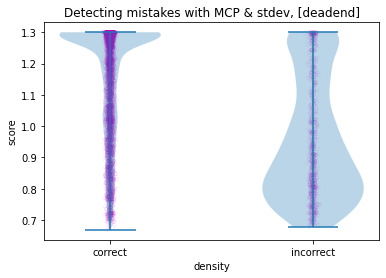

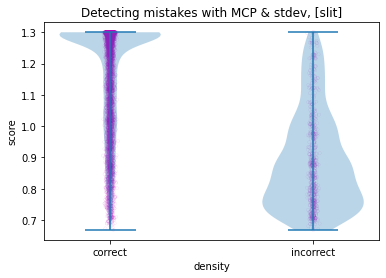

In [36]:
# Can the mean & stdev of ensemble together tell us whether the classifier is wrong?

for name, df in dfs.items():
    probabilities = df['probabilities']
    stdevs = df['stdevs']
    is_correct = df['is_correct']

    is_correct_indices = np.argwhere(is_correct).squeeze()
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct)).squeeze()

    # unbounded
    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    # ranges from 0 to 1
    max_class_probabilities_correct = make_max_class_prob(probabilities[is_correct_indices].squeeze()) * 2
    max_class_probabilities_incorrect = make_max_class_prob(probabilities[is_incorrect_indices].squeeze()) * 2
    combined_score_correct = combine_mcp_and_stdev_score(stdev_score(stdevs_correct), max_class_probabilities_correct)
    combined_score_incorrect = combine_mcp_and_stdev_score(stdev_score(stdevs_incorrect), max_class_probabilities_incorrect)

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with MCP & stdev, [{name}]')
    noisey_1d_scatter(ax, combined_score_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    noisey_1d_scatter(ax, combined_score_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    # widths = compute_widths([combined_score_correct, combined_score_incorrect])
    widths = [0.5, 0.5]
    ax.violinplot([combined_score_correct, combined_score_incorrect], [1, 2], widths=widths)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("score")